In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from scipy import interpolate
from scipy.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

In [2]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog
from jianbing import scatter

In [3]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

## Discussion about the outer envelope stellar mass as halo mass tracer

In [4]:
from sklearn.linear_model import LinearRegression

from ltsfit import lts_linefit

In [36]:
# Pre-compute
hsc_pre = Table.read(os.path.join(data_dir, 's16a_massive_logm_11.2.fits'))

mask = (
    (hsc_pre['logm_10_100'] >= 9.5) & (hsc_pre['logm_max'] >= 11.2) & 
    (hsc_pre['logm_50_100'] >= 9.5) & (hsc_pre['bsm_s18a']) & (hsc_pre['cen_mask_3'])
)

data_use = hsc_pre[mask]

#### ASAP Mvir v.s. M*100

[0.28889984] 7.677760414941746


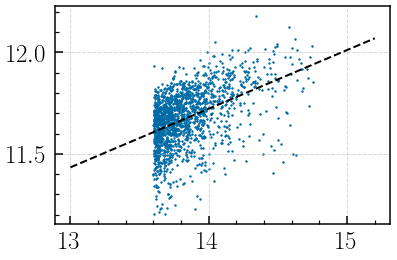

In [28]:
data_use[data_use['logm_cmod_err'] <= 0.02] = 0.02

mask = (data_use['logmh_vir_plane'] >= 13.6) & (data_use['logmh_vir_plane'] <= 14.9)

x_err = np.full(len(data_use[mask]), 0.04)
y_err = np.hypot(data_use[mask]['logm_cmod_err'], 0.03)

w = 1. / (y_err ** 2.)

x_arr, y_arr = data_use[mask]['logmh_vir_plane'], data_use[mask]['logm_100']

reg = LinearRegression().fit(
    x_arr[y_arr >= 10.2].reshape(-1, 1), y_arr[y_arr >= 10.2], 
    sample_weight=w[y_arr >= 10.2])

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.0, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')

sig_int:     0.0000      4.3914
Computing sig_int
sig_int:     0.0000      4.3914
sig_int:     0.1297     -0.2130
sig_int:     0.1237     -0.1471
sig_int:     0.1107      0.0244
sig_int:     0.1126     -0.0028
sig_int:     0.1124     -0.0000
sig_int:     0.1123      0.0008
Computing sig_int error
sig_int:     0.1124      0.0351
sig_int:     0.1297     -0.1779
sig_int:     0.1152     -0.0052
sig_int:     0.1149     -0.0001
sig_int:     0.1148      0.0007
Repeat at best fitting solution
sig_int:     0.1124     -0.0000
################# Values and formal errors ################
 intercept:  11.6578 +/- 0.0033
     slope:  0.303 +/- 0.014
   scatter:  0.1124 +/- 0.0025
Observed rms scatter: 0.12
y = a + b*(x - pivot) with pivot = 13.77
Spearman r=0.46 and p=1.6e-87
Pearson r=0.47 and p=7e-90
##########################################################
seconds 32.09


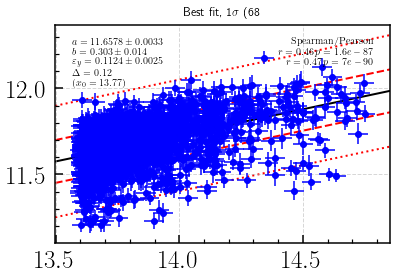

In [29]:
lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0
)

#### ASAP Mvir v.s. M*[10, 100]

[0.43733082] 5.401631158597449


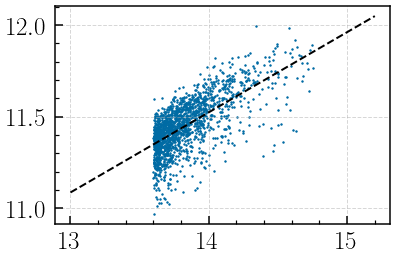

In [26]:
data_use[data_use['logm_cmod_err'] <= 0.02] = 0.02

mask = (data_use['logmh_vir_plane'] >= 13.6) & (data_use['logmh_vir_plane'] <= 14.9)

x_err = np.full(len(data_use[mask]), 0.04)
y_err = np.hypot(data_use[mask]['logm_cmod_err'], 0.03)

w = 1. / (y_err ** 2.)

x_arr, y_arr = data_use[mask]['logmh_vir_plane'], data_use[mask]['logm_10_100']

reg = LinearRegression().fit(x_arr.reshape(-1, 1), y_arr, sample_weight=w)

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.0, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')

sig_int:     0.0000      2.7696
Computing sig_int
sig_int:     0.0000      2.7696
sig_int:     0.1137     -0.2522
sig_int:     0.1042     -0.1409
sig_int:     0.0928      0.0255
sig_int:     0.0945     -0.0027
sig_int:     0.0944     -0.0000
sig_int:     0.0943      0.0007
Computing sig_int error
sig_int:     0.0944      0.0351
sig_int:     0.1137     -0.2171
sig_int:     0.0971     -0.0063
sig_int:     0.0967     -0.0002
sig_int:     0.0966      0.0006
Repeat at best fitting solution
sig_int:     0.0944     -0.0000
################# Values and formal errors ################
 intercept:  11.4243 +/- 0.0029
     slope:  0.457 +/- 0.012
   scatter:  0.0944 +/- 0.0023
Observed rms scatter: 0.11
y = a + b*(x - pivot) with pivot = 13.77
Spearman r=0.66 and p=1.4e-200
Pearson r=0.67 and p=2.4e-215
##########################################################
seconds 32.47


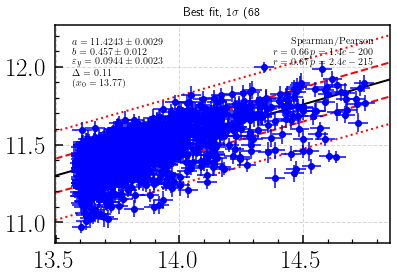

In [27]:
lts_linefit.lts_linefit(x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

#### ASAP Mvir v.s. M*[50, 100]

[0.57725264] 2.7963388216647482


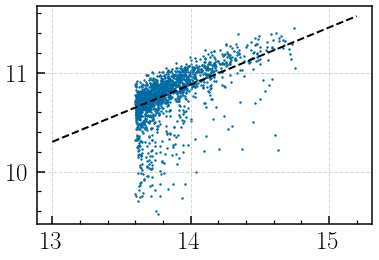

In [32]:
data_use[data_use['logm_cmod_err'] <= 0.02] = 0.02

mask = (data_use['logmh_vir_plane'] >= 13.6) & (data_use['logmh_vir_plane'] <= 14.9)

x_err = np.full(len(data_use[mask]), 0.03)
y_err = np.hypot(data_use[mask]['logm_cmod_err'], 0.03)

w = 1. / (y_err ** 2.)

x_arr, y_arr = data_use[mask]['logmh_vir_plane'], data_use[mask]['logm_50_100']

reg = LinearRegression().fit(
    x_arr[y_arr >= 10.2].reshape(-1, 1), y_arr[y_arr >= 10.2], 
    sample_weight=w[y_arr >= 10.2])

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.0, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')

sig_int:     0.0000      5.7598
Computing sig_int
sig_int:     0.0000      5.7598
sig_int:     0.1564     -0.2100
sig_int:     0.1509     -0.1583
sig_int:     0.1345      0.0279
sig_int:     0.1369     -0.0035
sig_int:     0.1366     -0.0001
sig_int:     0.1366      0.0008
Computing sig_int error
sig_int:     0.1366      0.0358
sig_int:     0.1564     -0.1741
sig_int:     0.1400     -0.0052
sig_int:     0.1396     -0.0001
sig_int:     0.1395      0.0007
Repeat at best fitting solution
sig_int:     0.1366     -0.0001
################# Values and formal errors ################
 intercept:  10.7474 +/- 0.0039
     slope:  0.676 +/- 0.017
   scatter:  0.1366 +/- 0.0029
Observed rms scatter: 0.15
y = a + b*(x - pivot) with pivot = 13.77
Spearman r=0.67 and p=1.9e-214
Pearson r=0.57 and p=7.4e-143
##########################################################
seconds 33.82


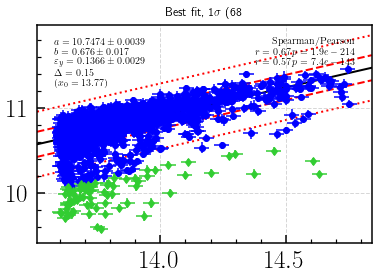

In [33]:
lts_linefit.lts_linefit(x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0)

In [38]:
mvir_grid = np.linspace(13.4, 15.2, 20)

m100_line = 11.6171 + 0.34 * (mvir_grid - 13.68)

m10_100_line = 11.4243 + 0.46 * (mvir_grid - 13.77)

m50_100_line = 10.7474 + 0.66 * (mvir_grid - 13.77)

#### Making the plot for the paper

Text(0, 0.5, '$\\log (M_{\\star, [50, 100]}/ M_{\\odot})$')

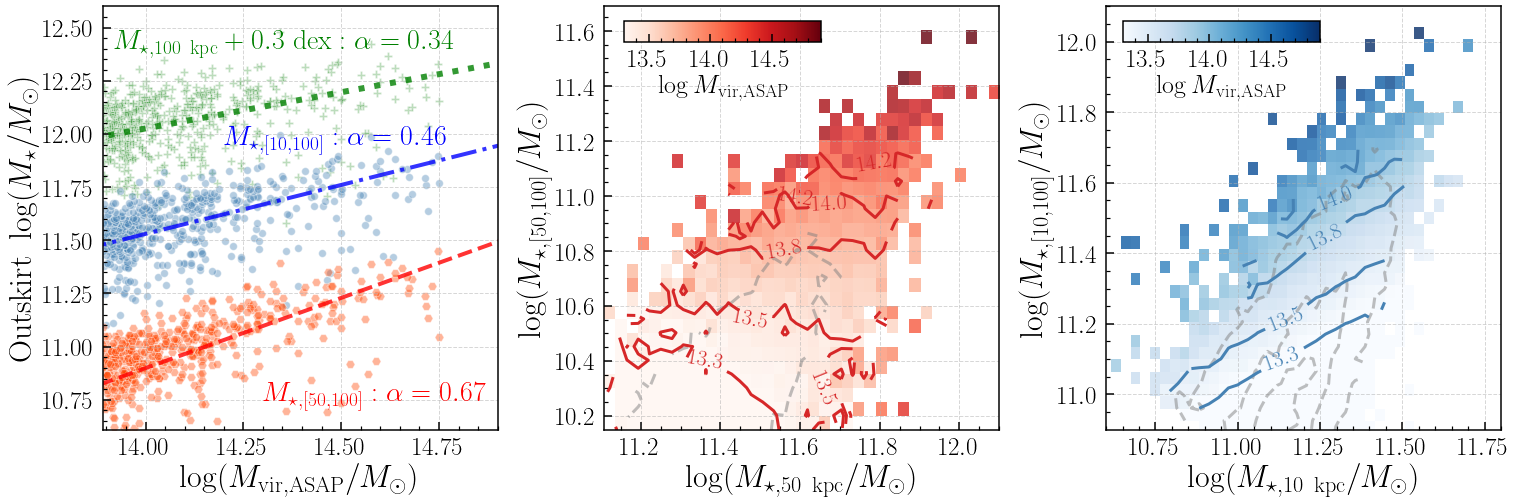

In [50]:
fig = plt.figure(figsize=(21, 7))
fig.subplots_adjust(
    left=0.065, bottom=0.15, right=0.99, top=0.99, wspace=0.27, hspace=None)

ax1 = fig.add_subplot(131)

x_mask = (data_use['logmh_vir_plane'] >= 13.4) & (data_use['cen_mask_3'])

# Tracer 1
z_stats_1, x_edges_1, y_edges_1, binnum_1 = binned_statistic_2d(
    data_use['logmh_vir_plane'][x_mask], data_use['logm_10_100'][x_mask], 
    data_use['logm_10_100'][x_mask], 
    'count', bins=[60, 40])
z_stats_1[z_stats_1 < 2] = np.nan

# Tracer 2
z_stats_2, x_edges_2, y_edges_2, binnum_2 = binned_statistic_2d(
    data_use['logmh_vir_plane'][x_mask], data_use['logm_50_100'][x_mask], 
    data_use['logm_10_100'][x_mask], 
    'count', bins=[60, 54])
z_stats_2[z_stats_2 < 2] = np.nan

#HM_1 = ax1.imshow(
#    z_stats_1.T, origin='lower', cmap='Blues', norm=LogNorm(vmin=1, vmax=300),
#    extent=[x_edges_1[0], x_edges_1[-1], y_edges_1[0], y_edges_1[-1]],
#    aspect='auto', interpolation='nearest', alpha=0.8)

#HM_2 = ax1.imshow(
#    z_stats_2.T, origin='lower', cmap='Reds', norm=LogNorm(vmin=1, vmax=100),
#    extent=[x_edges_2[0], x_edges_2[-1], y_edges_2[0], y_edges_2[-1]],
#    aspect='auto', interpolation='nearest', alpha=0.5)

#CT_1 = ax1.contour(
#    x_edges_1[:-1], y_edges_1[:-1], gaussian_filter(z_stats_1.T, 0.12),
#    5, linewidths=3.0, linestyles='solid', colors='steelblue', alpha=0.9, 
#    levels=[5, 20, 50], extend='neither')

#CT_2 = ax1.contour(
#    x_edges_2[:-1], y_edges_2[:-1], gaussian_filter(z_stats_2.T, 0.12),
#    5, linewidths=4.0, linestyles='dashed', colors='orangered', alpha=0.6, 
#    levels=[5, 20, 50], extend='neither')

ax1.scatter(data_use['logmh_vir_plane'][x_mask], data_use['logm_100'][x_mask] + 0.3, 
            s=60, alpha=0.3, facecolor='forestgreen', marker='P', edgecolor='w',
            label=r'$\log M_{\star, 100\ \rm kpc}$')
ax1.plot(mvir_grid, m100_line + 0.3, linestyle=':', linewidth=6, c='g', alpha=0.8)
ax1.text(13.92, 12.4, r'$M_{\star, 100\ \rm kpc} + 0.3\ {\rm dex}: \alpha=0.34$', 
         fontsize=28, color='green', alpha=1.0)

ax1.scatter(data_use['logmh_vir_plane'][x_mask], data_use['logm_10_100'][x_mask], 
            s=60, alpha=0.4, facecolor='steelblue', marker='o', edgecolor='w',
            label=r'$\log M_{\star, [10, 100]}$')
ax1.plot(mvir_grid, m10_100_line, linestyle='-.', linewidth=4, c='b', alpha=0.8)
ax1.text(14.20, 11.95, r'$M_{\star, [10, 100]}: \alpha=0.46$', 
         fontsize=28, color='blue', alpha=1.0)

ax1.scatter(data_use['logmh_vir_plane'][x_mask], data_use['logm_50_100'][x_mask], 
            s=80, alpha=0.4, color='orangered', marker='H', edgecolor='w',
            label=r'$\log M_{\star, [50, 100]}$')
ax1.plot(mvir_grid, m50_100_line, linestyle='--', linewidth=4, c='r', alpha=0.8)
ax1.text(14.3, 10.75, r'$M_{\star, [50, 100]}:\alpha=0.67$', 
         fontsize=28, color='red', alpha=1.0)

#ax1.legend(loc='best', fontsize=22, handletextpad=0.04)

ax1.set_xlim(13.89, 14.9)
ax1.set_ylim(10.61, 12.6)
ax1.set_xlabel(r'$\log (M_{\rm vir, ASAP}/ M_{\odot})$', fontsize=32)
ax1.set_ylabel(r'${\rm Outskirt\ } \log (M_{\star}/M_{\odot})$', fontsize=32)

ax2 = fig.add_subplot(133)

z_stats_3, x_edges_3, y_edges_3, binnum_3 = binned_statistic_2d(
    data_use['logm_10'], data_use['logm_10_100'], data_use['logmh_vir_plane'], 
    np.nanmean, bins=[40, 50])
z_count_3, _, _, _ = binned_statistic_2d(
    data_use['logm_10'], data_use['logm_10_100'], data_use['logmh_vir_plane'], 
    'count', bins=[40, 50])
z_stats_3[z_stats_3 < 2] = np.nan
z_count_3[z_count_3 < 2] = np.nan

HM_3 = ax2.imshow(
    z_stats_3.T, origin='lower', cmap='Blues', vmin=13.3, vmax=14.9,
    extent=[x_edges_3[0], x_edges_3[-1], y_edges_3[0], y_edges_3[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

CT_3 = ax2.contour(
    x_edges_3[:-1], y_edges_3[:-1], gaussian_filter(z_count_3.T, 0.1),
    5, linewidths=3.0, linestyles='dashed', colors='grey', alpha=0.5, 
    levels=[8, 50, 100], extend='neither')

CT_3b = ax2.contour(
    x_edges_3[:-1], y_edges_3[:-1], gaussian_filter(z_stats_3.T, 0.2),
    4, linewidths=3.0, alpha=1.0, colors='steelblue',
    levels=[13.3, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax2.clabel(CT_3b, inline=1, fontsize=22, colors='steelblue', fmt=r'$%4.1f$')

ax2.set_xlim(10.6, 11.8)
ax2.set_ylim(10.9, 12.1)
ax2.set_xlabel(r'$\log (M_{\star, 10\ \rm kpc}/ M_{\odot})$', fontsize=32)
ax2.set_ylabel(r'$\log (M_{\star, [10, 100]}/ M_{\odot})$', fontsize=32)

cax_3 = fig.add_axes([0.74, 0.92, 0.13, 0.04])
cbar_3 = plt.colorbar(HM_3, cax=cax_3, orientation='horizontal')
cbar_3.solids.set_edgecolor("face")
cax_3.set_xlabel(r'$\log M_{\rm vir, ASAP}$', fontsize=26)

ax3 = fig.add_subplot(132)

z_stats_4, x_edges_4, y_edges_4, binnum_4 = binned_statistic_2d(
    data_use['logm_50'], data_use['logm_50_100'], data_use['logmh_vir_plane'], 
    np.nanmean, bins=[35, 42])
z_count_4, _, _, _ = binned_statistic_2d(
    data_use['logm_50'], data_use['logm_50_100'], data_use['logmh_vir_plane'], 
    'count', bins=[35, 42])
z_stats_4[z_stats_4 < 5] = np.nan
z_count_4[z_count_4 < 5] = np.nan

HM_4 = ax3.imshow(
    z_stats_4.T, origin='lower', cmap='Reds', vmin=13.3, vmax=14.9,
    extent=[x_edges_4[0], x_edges_4[-1], y_edges_4[0], y_edges_4[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

CT_4 = ax3.contour(
    x_edges_4[:-1], y_edges_4[:-1], gaussian_filter(z_count_4.T, 0.15),
    5, linewidths=3.0, linestyles='dashed', colors='grey', alpha=0.5, 
    levels=[20, 100, 250], extend='neither')

CT_4b = ax3.contour(
    x_edges_4[:-1], y_edges_4[:-1], gaussian_filter(z_stats_4.T, 0.12),
    4, linewidths=3.0, alpha=1.0, colors='tab:red',
    levels=[13.3, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax3.clabel(CT_4b, inline=1, fontsize=22, colors='tab:red', fmt=r'$%4.1f$')
    
cax_4 = fig.add_axes([0.41, 0.92, 0.13, 0.04])
cbar_4 = plt.colorbar(HM_4, cax=cax_4, orientation='horizontal')
cbar_4.solids.set_edgecolor("face")
cax_4.set_xlabel(r'$\log M_{\rm vir, ASAP}$', fontsize=26)

ax3.set_ylim(10.15, 11.69)
ax3.set_xlabel(r'$\log (M_{\star, 50\ \rm kpc}/ M_{\odot})$', fontsize=32)
ax3.set_ylabel(r'$\log (M_{\star, [50, 100]}/ M_{\odot})$', fontsize=32)

In [51]:
fig.savefig(os.path.join(fig_dir, 'fig_12.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_12.pdf'), dpi=120)